# **Load Prediction by Hour**

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'alpha': 1, 'colsample_bytree': 0.9, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}


<ipython-input-1-8540a96edd9f>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = (xgb_preds + rf_preds) / 2  # Averaging ensemble


Ensemble RMSE Score on Test set: 178.00


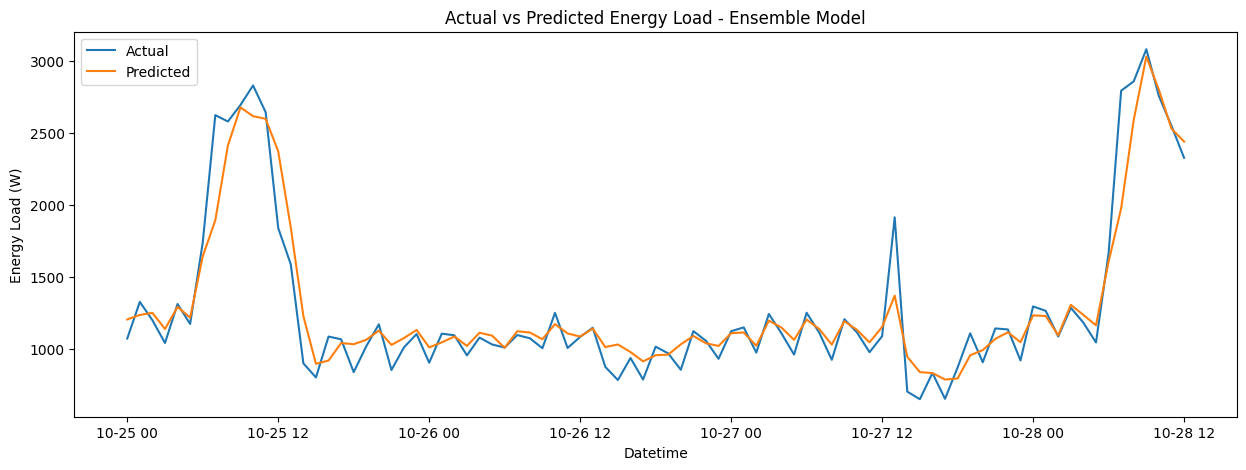

Predicted values saved to 'predicted_energy_load.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Load data
df = pd.read_csv('hourly_site_load_in_watt.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Feature Engineering with Additional Temporal Features
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # Cyclic transformations
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Lag features
    df['lag1'] = df['hourly_site_load_in_watt'].shift(1)
    df['lag2'] = df['hourly_site_load_in_watt'].shift(2)
    df['lag3'] = df['hourly_site_load_in_watt'].shift(3)
    df['lag6'] = df['hourly_site_load_in_watt'].shift(6)
    df['lag24'] = df['hourly_site_load_in_watt'].shift(24)

    # Rolling statistics
    df['rolling_mean_3'] = df['hourly_site_load_in_watt'].rolling(window=3).mean()
    df['rolling_std_3'] = df['hourly_site_load_in_watt'].rolling(window=3).std()
    df['rolling_mean_6'] = df['hourly_site_load_in_watt'].rolling(window=6).mean()
    df['rolling_std_6'] = df['hourly_site_load_in_watt'].rolling(window=6).std()
    df['rolling_mean_24'] = df['hourly_site_load_in_watt'].rolling(window=24).mean()
    df['rolling_std_24'] = df['hourly_site_load_in_watt'].rolling(window=24).std()

    return df.dropna()

df = create_features(df)

# Train/Test Split
train = df[df.index < '2024-10-25']
test = df[df.index >= '2024-10-25']

# Define features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1', 'lag2', 'lag3', 'lag6', 'lag24',
            'rolling_mean_3', 'rolling_std_3',
            'rolling_mean_6', 'rolling_std_6',
            'rolling_mean_24', 'rolling_std_24',
            'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
TARGET = 'hourly_site_load_in_watt'

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

# Model Hyperparameter Tuning with Additional Regularization Parameters
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [700, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 1, 10]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Ensemble with RandomForest for a blended prediction
rf_model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions and create an ensemble prediction
xgb_preds = best_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
test.loc[:, 'prediction'] = (xgb_preds + rf_preds) / 2


# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'Ensemble RMSE Score on Test set: {rmse:.2f}')

# Plot Actual vs Predicted
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['hourly_site_load_in_watt'], label='Actual')
plt.plot(test.index, test['prediction'], label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Energy Load (W)')
plt.legend()
plt.title('Actual vs Predicted Energy Load - Ensemble Model')
plt.show()

# Save predicted values to a CSV file with two decimal points
results = test[['hourly_site_load_in_watt', 'prediction']].copy()
results.columns = ['Actual Load (W)', 'Predicted Load (W)']
results = results.round(2)  # Round to 2 decimal places
results.to_csv('predicted_energy_load.csv', index=True)
print("Predicted values saved to 'predicted_energy_load.csv'")
